# Abstractive versus Extractive

In [5]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [6]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [7]:
## encoding
token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = [("Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:",
            'Q: What is the capital of Poland? Options: "A" Berlin, "B" Warsaw, "C" Paris A:'),
           ("Q: What is the relationship between Joe Biden and Donald Trump? A:",
            'Joe Biden and Donald Trump are enemies. Q: What is the relationship between Joe Biden and Donald Trump? A:'),
           ("Q: When was Trump born? A: 1946 Q: When was Barrack Obama born? A:",
            'Trump was born in 1946. Barrack Obama was born in 1961. Q: When was Barrack Obama born? A:'),
           ("The opposite of good is bad. The opposite of dark is",
            'Good-bad, dark-light. The opposite of good is bad. The opposite of dark is'),
           ("The second-largest country by area is Canada. What is the largest country by area?",
            'Russia is the largest country by area. What is the largest country by area?')
          ]

example = 2
logits_0, activs_0, tokens_0 = decoding.encode(prompts[example][0], model)
logits_1, activs_1, tokens_1 = decoding.encode(prompts[example][1], model)

In [11]:
data = list()
layer = 5

for example in range(0,len(prompts)):
    logits_0, activs_0, tokens_0 = decoding.encode(prompts[example][0], model)
    logits_1, activs_1, tokens_1 = decoding.encode(prompts[example][1], model)

    x_0 = activs_0[f"blocks.{layer}.hook_mlp_out"][...,-1,:]
    x_1 = activs_1[f"blocks.{layer}.hook_mlp_out"][...,-1,:]
    
    x_01 = (x_0 + x_1) / 2
    x_0 = x_0 - x_01
    x_1 = x_1 - x_01
    
    
    data.append(x_0)
    data.append(x_1)
    
x = torch.stack(data).squeeze().numpy()
x.shape

(10, 1024)

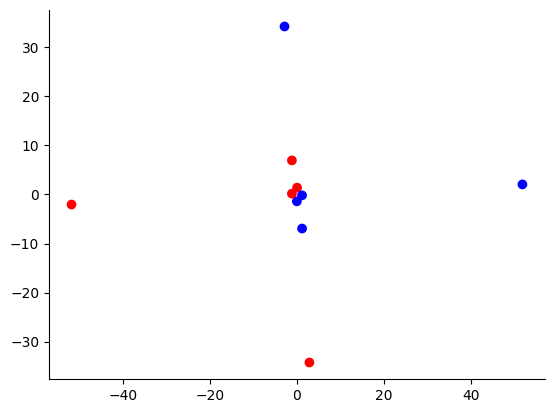

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


colors = ["red", "blue"]*int(x.shape[0] / 2)

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(x)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=colors)
plt.show()